# 02 - Exploratory Data Analysis

## 1. Import Packages <a name="import"></a>

Here we combine the data from our .csv files for some exploratory data analysis. <br>
We will also perform some initial modeling before pickling the results.

In [85]:
import re
import pandas as pd
import numpy as np
import random

In [160]:
%matplotlib inline
import csv
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Combine Data](#combine)
3. [Cleaning Data](#clean)
4. [Visualizing Correlations](#corr)
5. [Initial Modeling with StatsModels](#model)
5. [Potential Transformations](#transform)


## 2. Combine Data <a name="combine"></a>

We will be using a combination of BeautifulSoup and Selenium to fetch data from U.S. News & World Report.

In [286]:
def csv_files_to_df():
    """
        Function to combine .csv files with article info together into dataframe
        
        :returns combined: pandas dataframe with all article info together
    """
    
    file_dir = os.path.abspath('.')
    csv_folder = 'data'
    
    years = [str(2009+i) for i in range(0, 10)]
    df_list = []

    for year in years:
        path = os.path.join(file_dir, csv_folder, year + '_article_metrics.csv')
        df = pd.read_csv(path)
        df_list.append(df)

    combined = (pd.concat(df_list)
                  .reset_index()
                  .drop(columns = ['Unnamed: 0', 'index'])
                  .rename(columns = {'num_insitutions': 'num_institutions'}))
    return combined

combined = csv_files_to_df()
combined

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1.0,1.0,1.0,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1.0,1.0,1.0,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0.0,0.0,0.0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0.0,0.0,0.0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1.0,1.0,1.0,1,2,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,9,146,40,29,5,4,40,NaN,NaN,NaN,9,0.0,0.0,0.0,1,3,2018
1579,9,34,9,19,5,7,40,NaN,NaN,NaN,2,0.0,0.0,0.0,1,1,2018
1580,8,1175,55,44,3,6,35,NaN,NaN,NaN,8,0.0,1.0,1.0,1,4,2018
1581,10,1984,45,29,6,10,46,NaN,NaN,NaN,12,0.0,0.0,0.0,1,3,2018


Return to [Table of Contents](#table)

## 3. Cleaning Data <a name="clean"></a>

We check the number of null-values for each column. <br>
A significant number of null values exist for "mean_author_citations", "mean_h_index", and "mean_i10_index". <br>
There are a couple of scenarios. <br>
It could be that not many research authors have a Google Scholar profile yet. <br>
It is also possible scraping failed since Google has a rate limit of 120 scrapes per hour. <br>

In [287]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 17 columns):
title_length             1583 non-null int64
altmetric                1583 non-null int64
num_times_cited          1583 non-null int64
abstract_length          1583 non-null int64
page_length              1583 non-null int64
fig_count                1583 non-null int64
ref_cnt                  1583 non-null int64
mean_author_citations    80 non-null float64
mean_h_index             80 non-null float64
mean_i10_index           80 non-null float64
num_authors              1583 non-null int64
top20                    1574 non-null float64
top50                    1574 non-null float64
top100                   1574 non-null float64
other                    1583 non-null int64
num_institutions         1583 non-null int64
year                     1583 non-null int64
dtypes: float64(6), int64(11)
memory usage: 210.4 KB


If values for institution for "top20", "top50", and "top100" are NaN, then the value for 'other' should be 1, indicating that the research was conducted at a institution that is not a university and/or within the top 100 schools. 

In [288]:
na_rank_indices = combined[combined['top20'].isna()].index
combined.loc[na_rank_indices, 'top20'] = 0 
combined.loc[na_rank_indices, 'top50'] = 0
combined.loc[na_rank_indices, 'top100'] = 0 
combined.loc[na_rank_indices, 'other'] = 1 

combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1.0,1.0,1.0,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1.0,1.0,1.0,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0.0,0.0,0.0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0.0,0.0,0.0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1.0,1.0,1.0,1,2,2009


In [289]:
combined['top20'] = combined['top20'].astype(np.uint8)
combined['top50'] = combined['top50'].astype(np.uint8)
combined['top100'] = combined['top100'].astype(np.uint8)
combined['other'] = combined['other'].astype(np.uint8)
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1,1,1,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1,1,1,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0,0,0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0,0,0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1,1,1,1,2,2009


We will have to drop the "mean_author_citations", "mean_h_index", "mean_i10_index" columns for now. 
Our results will possibly be worse. In the future, robust scraping methods could be used to collect the data.

In [290]:
mean_metric_cols = ['mean_author_citations', 'mean_h_index', 'mean_i10_index']

combined = combined.drop(columns = mean_metric_cols)
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,1,1,2,2009
1,8,6,112,59,5,8,42,5,1,1,1,1,5,2009
2,10,24,551,62,5,7,38,33,0,0,0,1,9,2009
3,9,33,647,51,7,10,52,14,0,0,0,1,12,2009
4,7,1,473,57,5,10,49,6,1,1,1,1,2,2009


In [291]:
combined['year'] = combined['year'].apply(lambda x: 2019 - int(x))

Ideally, the columns "num_times_cited", "num_authors", and "num_institutions" should not have 0 values. <br>
For each column, we will use the median as a placeholder value.

In [292]:
check_cols = ["num_times_cited", "num_authors", "num_institutions"]

for col in check_cols:
    combined.loc[combined[col]==0, col] = round(combined[col].median())

In [293]:
#check for missing values
for col in combined.columns:
    missing = combined[combined[col].isna()].shape[0]
    print('Number of Missing Values in ' + col + ': ' + str(missing))

Number of Missing Values in title_length: 0
Number of Missing Values in altmetric: 0
Number of Missing Values in num_times_cited: 0
Number of Missing Values in abstract_length: 0
Number of Missing Values in page_length: 0
Number of Missing Values in fig_count: 0
Number of Missing Values in ref_cnt: 0
Number of Missing Values in num_authors: 0
Number of Missing Values in top20: 0
Number of Missing Values in top50: 0
Number of Missing Values in top100: 0
Number of Missing Values in other: 0
Number of Missing Values in num_institutions: 0
Number of Missing Values in year: 0


In [294]:
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,1,1,5,10
2,10,24,551,62,5,7,38,33,0,0,0,1,9,10
3,9,33,647,51,7,10,52,14,0,0,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,1,1,2,10


Return to [Table of Contents](#table)

## 4. Visualizing Correlations <a name="corr"></a>

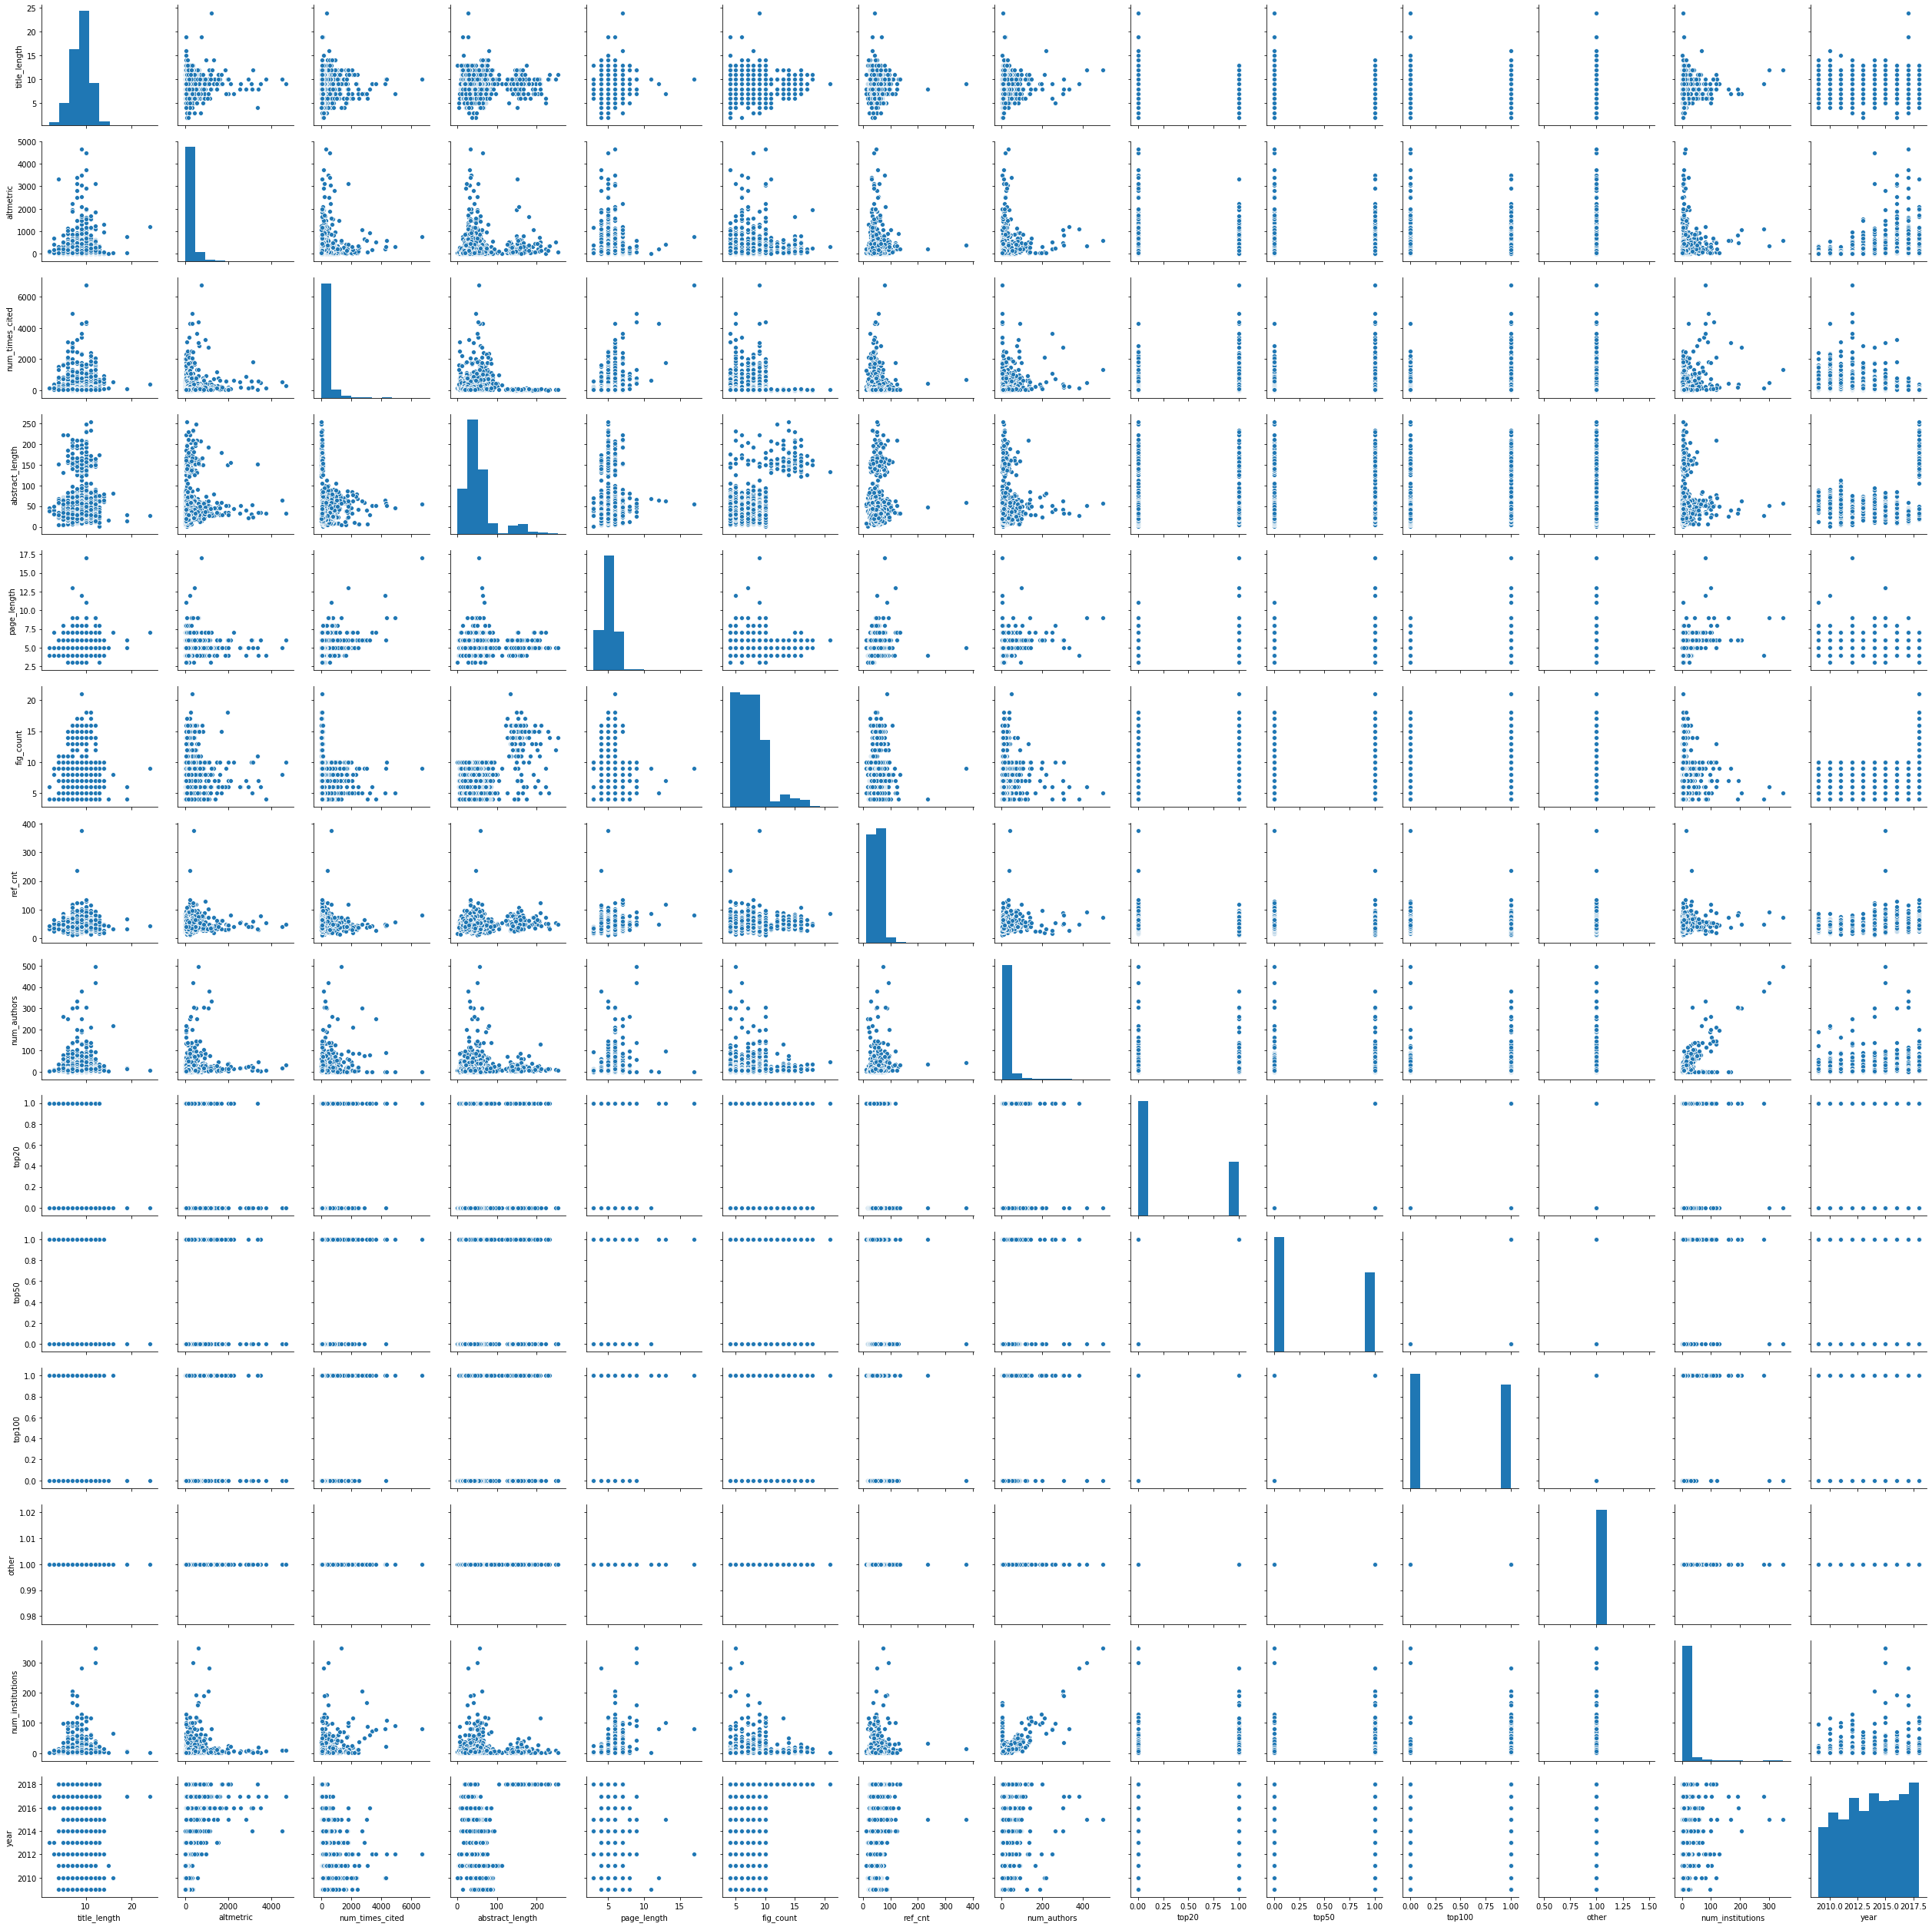

In [108]:
sns.pairplot(combined);

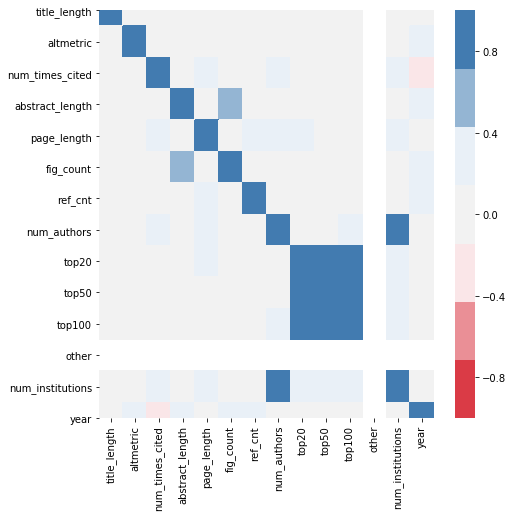

In [130]:
plt.figure(figsize = [7.5, 7.5]);
sns.heatmap(combined.corr(), cmap=sns.diverging_palette(10, 245, sep=80, n=7), vmin = -1, vmax = 1);

There are some high correlations among "top20", "top50", and "top100" columns and between "num_authors" and "num_institutions".<br>
For now, I will drop the "top20" and "top50" columns.

In [295]:
combined = combined.drop(columns = ['top20', 'top50'])
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,5,10
2,10,24,551,62,5,7,38,33,0,1,9,10
3,9,33,647,51,7,10,52,14,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,2,10


Return to [Table of Contents](#table)

## 5. Initial Modeling with StatsModels <a name="model"></a>

We will try some initial modeling with StatsModels because of its ability to generate a handy summary. <br>
Our independent variable is the altmetric score.

In [296]:
df = combined.copy()
df.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,5,10
2,10,24,551,62,5,7,38,33,0,1,9,10
3,9,33,647,51,7,10,52,14,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,2,10


In [297]:
X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)

fit1 = model.fit() 
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     21.48
Date:                Tue, 11 Feb 2020   Prob (F-statistic):           2.77e-37
Time:                        13:02:07   Log-Likelihood:                -9261.9
No. Observations:                1266   AIC:                         1.855e+04
Df Residuals:                    1255   BIC:                         1.860e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              251.3673     46.189      5.442      0.000     160.750     341.984
title_length         6.6093      5.471      1.208      0.227      -4.125      17.344
num_times_cited      0.1441      0.026      5.559      0.000       0.093       0.195
abstract_length     -0.4140      0.302     -1.370      0.171      -1.007       0.179
page_length         -2.4681     13.284     -0.186      0.853     -28.530      23.594
fig_count           -4.8306      4.410     -1.095      0.274     -13.482       3.821
ref_cnt             -1.0856      0.598     -1.815      0.070      -2.259       0.088
num_authors          1.1146      0.466      2.392      0.017       0.201       2.029
top100              -3.7508     21.209     -0.177      0.860     -45.359      37.857
other              251.3673     46.189      5.442      0.000     160.750     341.984
num_institutions    -0.3923      0.789     -0.497      0.619      -1.940       1.156
year               -55.6676      4.183    -13.309      0.000     -63.874     -47.462
==============================================================================
Omnibus:                     1399.958   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99336.114
Skew:                           5.506   Prob(JB):                         0.00
Kurtosis:                      44.975   Cond. No.                     2.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.25e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The initial model has high multicollinearity and the results are rather terrible. <br>
There are many things we can try to improve the model. <br>
For example, we could standardize the data and remove features to help with multi-collinearity <br>
We could also log-transform our dependent variable since it is non-negative. 

Return to [Table of Contents](#table)

## 6. Potential Transformations <a name="transform"></a>

Here we are examining some possible transformations that could be applied to make our results better. <br>
Changing the scale types for plots helps us visualize the effects of using log transforms.

In [298]:
df = combined.copy()
df.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,5,10
2,10,24,551,62,5,7,38,33,0,1,9,10
3,9,33,647,51,7,10,52,14,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,2,10


In [299]:
#pickle the data so far
df.to_pickle('./data/combined_article_metrics.pkl')

In [233]:
col_dict = {"title_length": "Title Length",
            "altmetric": "Altmetric",
            "num_times_cited": "Number of Times Cited", 
            "abstract_length": "Abstract Length",
            "page_length": "Page Length",
            "fig_count": "Number of Figures",
            "ref_cnt": "Number of References",
            "num_authors": "Number of Authors",
            "num_institutions": "Number of Institutions",
            "year": "Number of Years Since Publication" }

def transform_visualizer(df, x_var, y_var, x_scale, y_scale, col_dict, savefig = False):
    """
        Function that produces a plot, given the dataframe
        
        :param df: pandas dataframe
        :param x_var: independent variable to plot
        :param y_var: dependent variable to plot
        :param x_scale: type of x axis, "log", "linear", "symlog", "logit"
        :param y_scale: type of y axis, "log", "linear", "symlog", "logit"
    """
    
    plt.figure(figsize= (5,5))
    sns.set_style("whitegrid")
    ax = sns.scatterplot(df[x_var], df[y_var], alpha = 0.75)
    ax.set(xscale=x_scale, yscale=y_scale);
    plt.xlabel(xlabel=col_dict[x_var], y=1.25, fontsize = 12, weight= 'bold')
    plt.ylabel(ylabel=col_dict[y_var], x=1.05, fontsize = 12, weight = 'bold')
    plt.xlim([1, df[x_var].max()])
    plt.ylim([1, df[y_var].max()])
    plt.title(label = col_dict[y_var] + ' vs ' + col_dict[x_var], 
              fontsize = 15, y = 1.025, weight='bold');
    
    if savefig:
        plt.savefig("./img/" + col_dict[y_var] + ' vs ' + col_dict[x_var] + ".png")

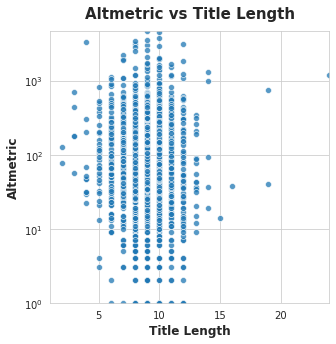

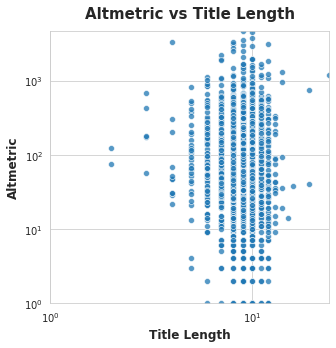

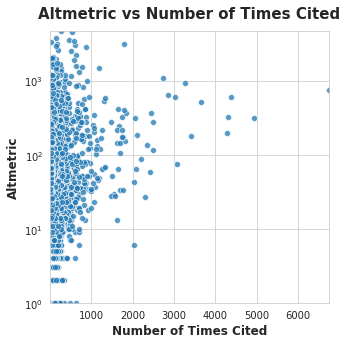

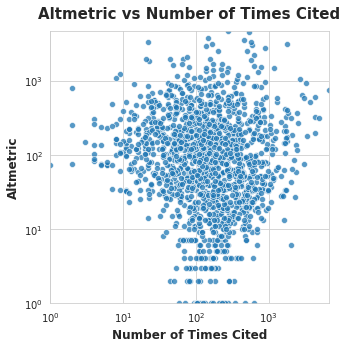

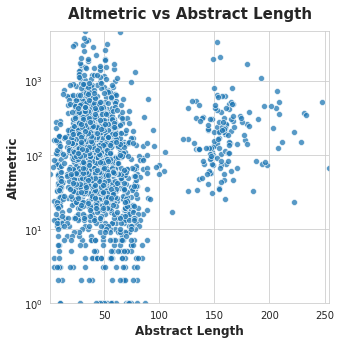

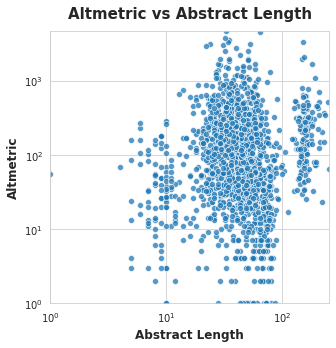

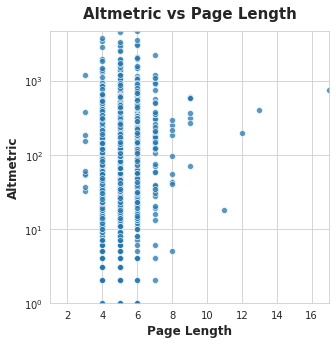

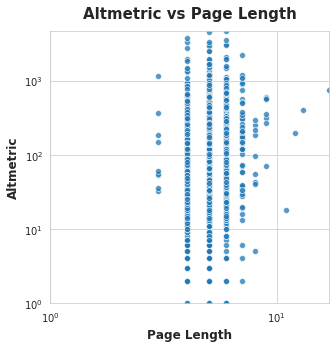

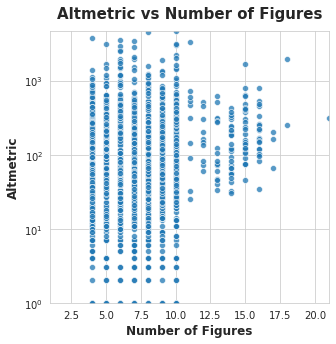

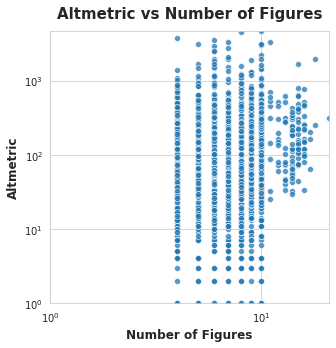

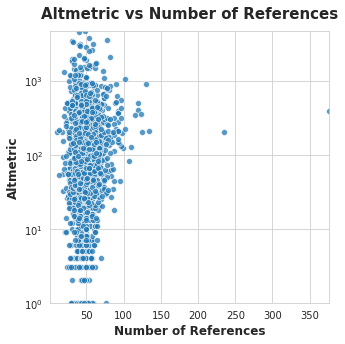

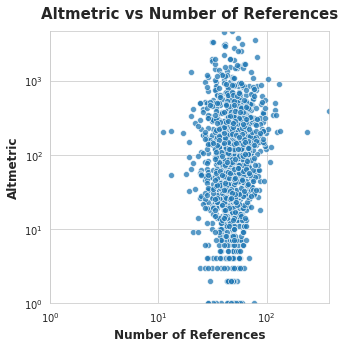

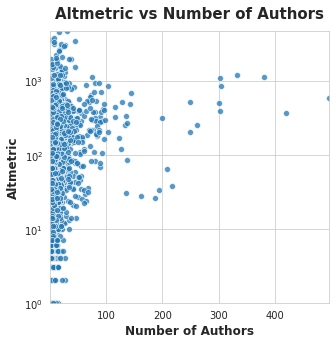

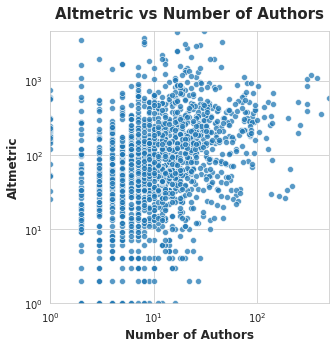

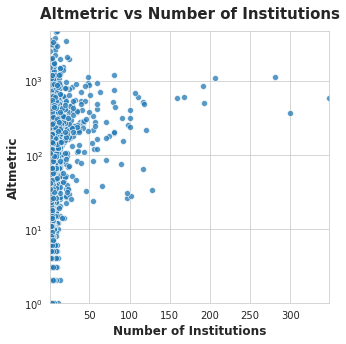

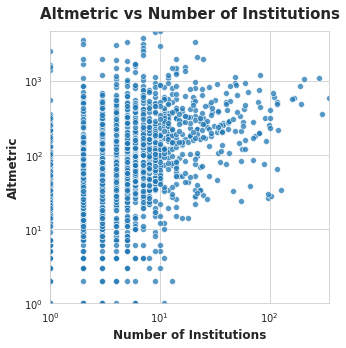

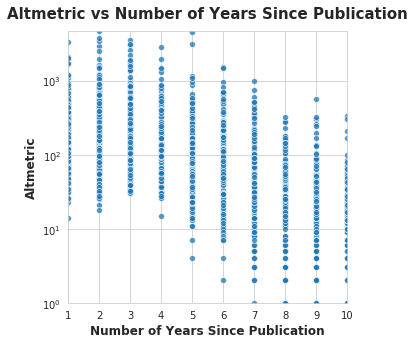

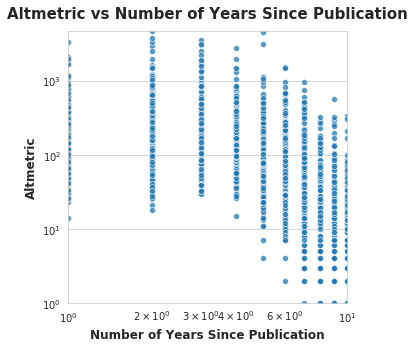

In [234]:
for col in df.columns:
    if col != 'altmetric':
        if col != 'other' and col != 'top100':
            transform_visualizer(df, col, 'altmetric', 'linear', 'log', col_dict)
            transform_visualizer(df, col, 'altmetric', 'log', 'log', col_dict)

"num_times_cited", "num_institutions", and "num_authors" could be log-transformed for better model performance.

Return to [Table of Contents](#table)